# Libraries imports and random seeds setting

In [1]:
import pandas as pd
import numpy as np
from pyDOE import lhs
import tqdm
import shap
import torch
import gpytorch
import botorch
import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(0)

# Descriptor scaling functions

In [2]:
def min_max_scaling(tensor):
    min_vals = torch.tensor([x[0] for x in optimization_space]).unsqueeze(0)
    max_vals = torch.tensor([x[1] for x in optimization_space]).unsqueeze(0)
    scaled_tensor = (tensor - min_vals) / (max_vals - min_vals)
    return scaled_tensor

def inverse_min_max_scaling(scaled_tensor):
    min_vals = torch.tensor([x[0] for x in optimization_space]).unsqueeze(0)
    max_vals = torch.tensor([x[1] for x in optimization_space]).unsqueeze(0)
    return scaled_tensor * (max_vals - min_vals) + min_vals

# Helper function for the preparation and scaling of the dataset

In [3]:
def prepare_and_scale_data(pandas_dataset,selected_descriptors):
    unscaled_tensor = torch.tensor(pandas_dataset[selected_descriptors].to_numpy(), dtype=torch.float32)
    scaled_tensor = min_max_scaling(unscaled_tensor)
    train_x = scaled_tensor
    train_y = torch.tensor(pandas_dataset[maximized_value].to_numpy(), dtype=torch.float32).squeeze(-1) / 100
    return train_x, train_y

# Compute and track the norm of the exploration vector from the current best obversation

In [4]:
def extract_current_best(df, composition):
    
    filtered_df = df[df.iloc[:, 2].isin([composition*100])]
    max_purity_idx = filtered_df.iloc[:, 1].idxmax()
    best_condition = df.iloc[max_purity_idx, 2:].astype(np.float32)
    numpy_best_condition = best_condition.to_numpy()
    torch_best_condition = torch.tensor(numpy_best_condition, dtype=torch.float32)
    return min_max_scaling(torch_best_condition)


def norm_vector_exploration(new, best):
    
    deplacement = torch.sub(new, best)
    norm_deplacement = torch.norm(deplacement, p=2)
    return norm_deplacement

# Instentiation and training of the GP using a constant mean and RBFKernel

In [5]:
class ARDGPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    
    num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_dim)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        predictions = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
        return predictions



def trainModel(train_x, train_y):
    
    noise = 1e-4
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ARDGPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    model.train()
    likelihood.train()

    for i in range(2000):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
    model.eval()
    likelihood.eval()
    return model, likelihood


def printModelParameters(model):
    
    print('Model parameters at current iteration:\n')
    for name, param in model.mean_module.named_parameters():
        print(f'{name}: {param.data}')
    print(f'Outputscale: {model.covar_module.outputscale.item()}')
    print(f'refined lenghtscale: {model.covar_module.base_kernel.lengthscale.data}\n\n')

# Score policies and prediction of next queries

In [6]:
def define_score_policy(model, score_policy):
    
    if score_policy == 'PI':
        policy = botorch.acquisition.analytic.ProbabilityOfImprovement(model, best_f = train_y.max())
        
    elif score_policy == 'EI':
        policy = botorch.acquisition.analytic.LogExpectedImprovement(model, best_f = train_y.max())
        
    return policy

In [7]:
def prediction_next_queries(df, model, policy, targeted_compositions, iteration, pretty_printing=True, vect_exploration=True):

    next_queries = []

    for targeted_composition in targeted_compositions:

        lb, hb = [0 for _ in range(num_dim)], [1 for _ in range(num_dim)]
        lb[0] = targeted_composition
        hb[0] = targeted_composition

        next_x, acq_val = botorch.optim.optimize_acqf(
            policy,
            bounds=torch.tensor([lb,hb], dtype=torch.float),
            q=1,
            num_restarts=10,
            raw_samples=1000,
        )
    
        with torch.no_grad():
            predictive_next_x = model(next_x)
            predictive_mean_next_x = predictive_next_x.mean
            
        if vect_exploration:
            current_best_observation = extract_current_best(df, targeted_composition)
            vector = norm_vector_exploration(next_x, current_best_observation)
        else:
            vector = None
        
        unscaled_predictions = inverse_min_max_scaling(next_x)
        prediction_target = predictive_mean_next_x
        next_queries.append((unscaled_predictions,prediction_target, vector))

    if pretty_printing:
        for nb_query in range(len(next_queries)):  
            print(f'The new conditions for sample {nb_query+1} of iteration {iteration} are:\n')
            unscaled_predictions, prediction_target, vec = next_queries[nb_query]
            for descriptor in range(unscaled_predictions.size(1)):
                print(f'{descriptors[descriptor]}: {unscaled_predictions[0,descriptor]:.1f}')
            print(f'\n{maximized_value[0]}: {prediction_target[0]*100:.0f}\n')
            if vect_exploration: 
                print(f'Norm of exploration vector: {vec:.2f}\n\n')
    return next_queries

# Set-up BO optimization space 

In [8]:
maximized_value = ['Purity (wt. %)']

descriptors = ['Fe stoichiometry (mol. %)',
               'Duration BM (min)',
               'Excess SiO2 (mol. %)',
               'Pressure pellet (MPa)',
               'Temperature max. (K)',
               'Duration reac. (h)',
               'Heating rate (K/h)',
                ]

optimization_space = [(  0.0,  100.0), # Fe stoichiometry (mol. %)
                      (  0.0,  720.0), # Duration BM (min)
                      (  0.0,   30.0), # Excess SiO2 (mol. %)',
                       (10.0,  300.0), # Pressure pellet (MPa)
                     (1073.0, 1473.0), # Temperature max. (K)
                      (  0.0,   60.0), # Duration reac. (h)
                      ( 40.0,  300.0), # Heating rate (K/h)
                     ]

num_dim = len(descriptors)

targeted_compositions = [0, 0.6, 1] #Correspond to Mn_5Si_3, Mn_2Fe_3Si_5 and Fe_5Si_3, respectively.

# Generation of randomnly distributed synthesis condition for the initial dataset using the Latin HyperCube method 

In [9]:
def generate_initial_db(n_inital_samples, num_dim, pretty_print=True):
    
    inital_design = lhs(num_dim, samples=n_inital_samples, criterion='center')
    lower_bounds = np.zeros(num_dim)
    upper_bounds = np.ones(num_dim)
    scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * inital_design
    unscaled_samples = inverse_min_max_scaling(torch.tensor(scaled_samples))

    if pretty_print:
        for sample in range(n_inital_samples):  
            print(f'Proposed conditions for sample {sample+1} are:\n')
            for descriptor in range(len(descriptors)):
                print(f'{descriptors[descriptor]}: {unscaled_samples[sample,descriptor]:.1f}')
            print('\n')

In [10]:
generate_initial_db(7, num_dim)

Proposed conditions for sample 1 are:

Fe stoichiometry (mol. %): 50.0
Duration BM (min): 154.3
Excess SiO2 (mol. %): 23.6
Pressure pellet (MPa): 196.4
Temperature max. (K): 1444.4
Duration reac. (h): 47.1
Heating rate (K/h): 207.1


Proposed conditions for sample 2 are:

Fe stoichiometry (mol. %): 92.9
Duration BM (min): 257.1
Excess SiO2 (mol. %): 6.4
Pressure pellet (MPa): 113.6
Temperature max. (K): 1330.1
Duration reac. (h): 12.9
Heating rate (K/h): 132.9


Proposed conditions for sample 3 are:

Fe stoichiometry (mol. %): 7.1
Duration BM (min): 51.4
Excess SiO2 (mol. %): 10.7
Pressure pellet (MPa): 155.0
Temperature max. (K): 1215.9
Duration reac. (h): 38.6
Heating rate (K/h): 281.4


Proposed conditions for sample 4 are:

Fe stoichiometry (mol. %): 35.7
Duration BM (min): 360.0
Excess SiO2 (mol. %): 15.0
Pressure pellet (MPa): 72.1
Temperature max. (K): 1158.7
Duration reac. (h): 55.7
Heating rate (K/h): 170.0


Proposed conditions for sample 5 are:

Fe stoichiometry (mol. %): 21

# Generating the initial dataset 

In [11]:
initial_data = [['SLT_BO1',  72.0,   60.0, 140.0,  0.0,  35.0, 1173.0,  7.0,  90.0],
                ['SLT_BO2',  88.0,   25.0, 400.0,  0.0,  52.5, 1173.0,  5.0,  80.0],
                ['SLT_BO4',  64.0,   85.0, 540.0,  0.0, 175.5, 1073.0, 60.0, 250.0], 
                ['SLT_BO6',  72.0,    5.0, 540.0,  0.0, 195.0, 1223.0, 24.0, 200.0], 
                ['SLT_BO7',  70.0,   95.0, 680.0,  0.0, 280.0, 1423.0, 43.0, 250.0], 
                ['SLT_BO10',  79.0,  15.0,  40.0,  0.0,  70.0, 1273.0, 60.0, 150.0],
                ['SLT_BO11',  86.0,   0.0,   0.0,  0.0, 230.0, 1273.0, 35.0, 100.0], 
                ['SLT_BO12',  14.0, 100.0,   0.0,  0.0, 230.0, 1273.0, 35.0, 100.0],
                ['SLT_BO14',  94.7,   5.0, 180.0, 10.0, 112.5, 1273.0, 14.5, 250.0],
                ['SLT_BO15',  75.8,  85.0, 360.0,  5.0, 187.5, 1373.0, 35.0, 100.0],
                ['SLT_BO16',  67.0,  70.0, 510.0, 30.0,  38.8, 1273.0, 42.5, 250.0],
                ['SLT_BO17', 100.0,  30.0, 360.0, 20.0, 155.0, 1423.0, 18.0,  70.0],
                ['SLT_BO18',  84.5,  90.0, 210.0, 15.0, 280.0, 1273.0, 34.5, 150.0],
                ['SLT_BO19',  89.0,  50.0,  60.0, 10.0, 200.0, 1223.0, 14.0, 300.0],
                ['SLT_BO20', 100.0,  10.0, 660.0, 20.0, 100.0, 1373.0,  6.0, 100.0],
               ]

columns_name = ['Sample name'] + maximized_value + descriptors

In [12]:
df_0 = pd.DataFrame(initial_data, columns=columns_name)
df_0

,Sample name,Purity (wt. %),Fe stoichiometry (mol. %),Duration BM (min),Excess SiO2 (mol. %),Pressure pellet (MPa),Temperature max. (K),Duration reac. (h),Heating rate (K/h)
0,SLT_BO1,72.0,60.0,140.0,0.0,35.0,1173.0,7.0,90.0
1,SLT_BO2,88.0,25.0,400.0,0.0,52.5,1173.0,5.0,80.0
2,SLT_BO4,64.0,85.0,540.0,0.0,175.5,1073.0,60.0,250.0
3,SLT_BO6,72.0,5.0,540.0,0.0,195.0,1223.0,24.0,200.0
4,SLT_BO7,70.0,95.0,680.0,0.0,280.0,1423.0,43.0,250.0
5,SLT_BO10,79.0,15.0,40.0,0.0,70.0,1273.0,60.0,150.0
6,SLT_BO11,86.0,0.0,0.0,0.0,230.0,1273.0,35.0,100.0
7,SLT_BO12,14.0,100.0,0.0,0.0,230.0,1273.0,35.0,100.0
8,SLT_BO14,94.7,5.0,180.0,10.0,112.5,1273.0,14.5,250.0
9,SLT_BO15,75.8,85.0,360.0,5.0,187.5,1373.0,35.0,100.0


# 1$^{st}$ iteration of the BO with EI policy

In [13]:
iteration = 1
train_x, train_y = prepare_and_scale_data(df_0, descriptors)
trained_model, trained_likelihood = trainModel(train_x, train_y)
printModelParameters(trained_model)
policy = define_score_policy(trained_model, "EI")
next_queries = prediction_next_queries(df_0, trained_model, policy, targeted_compositions, iteration)

Model parameters at current iteration:

raw_constant: 0.5491565465927124
Outputscale: 0.1011437326669693
refined lenghtscale: tensor([[0.6578, 0.8332, 0.4834, 6.2811, 7.5972, 2.4774, 5.9911]])


The new conditions for sample 1 of iteration 1 are:

Fe stoichiometry (mol. %): 0.0
Duration BM (min): 496.1
Excess SiO2 (mol. %): 15.7
Pressure pellet (MPa): 300.0
Temperature max. (K): 1073.0
Duration reac. (h): 0.0
Heating rate (K/h): 40.0

Purity (wt. %): 98

Norm of exploration vector: 1.20


The new conditions for sample 2 of iteration 1 are:

Fe stoichiometry (mol. %): 60.0
Duration BM (min): 581.9
Excess SiO2 (mol. %): 13.3
Pressure pellet (MPa): 45.0
Temperature max. (K): 1455.9
Duration reac. (h): 0.0
Heating rate (K/h): 40.0

Purity (wt. %): 113

Norm of exploration vector: 1.06


The new conditions for sample 3 of iteration 1 are:

Fe stoichiometry (mol. %): 100.0
Duration BM (min): 720.0
Excess SiO2 (mol. %): 14.3
Pressure pellet (MPa): 10.0
Temperature max. (K): 1285.6
Duration re

In [14]:
new_results = [['SLT_BO21',  21.6,   0.0, 485.0, 15.8, 300.0, 1073.0,  0.0,  40.0],
               ['SLT_BO22',  97.1,  60.0, 552.0, 13.0, 62.0, 1423.0,  0.0,  40.0],
               ['SLT_BO23',  98.2, 100.0, 720.0, 14.0, 10.0, 1363.0,  0.0,  40.0],
              ]

df_0_new = pd.DataFrame(new_results, columns=columns_name)
df_1 = pd.concat([df_0, df_0_new], ignore_index=True)

# 2$^{nd}$ iteration of the BO with EI policy

In [15]:
iteration = 2
train_x, train_y = prepare_and_scale_data(df_1, descriptors)
trained_model, trained_likelihood = trainModel(train_x, train_y)
policy = define_score_policy(trained_model, "EI")
next_queries = prediction_next_queries(df_1, trained_model, policy, targeted_compositions, iteration)

The new conditions for sample 1 of iteration 2 are:

Fe stoichiometry (mol. %): 0.0
Duration BM (min): 48.7
Excess SiO2 (mol. %): 15.1
Pressure pellet (MPa): 300.0
Temperature max. (K): 1362.8
Duration reac. (h): 8.9
Heating rate (K/h): 40.0

Purity (wt. %): 98

Norm of exploration vector: 0.78


The new conditions for sample 2 of iteration 2 are:

Fe stoichiometry (mol. %): 60.0
Duration BM (min): 429.0
Excess SiO2 (mol. %): 16.6
Pressure pellet (MPa): 163.8
Temperature max. (K): 1357.5
Duration reac. (h): 9.2
Heating rate (K/h): 136.3

Purity (wt. %): 106

Norm of exploration vector: 0.60


The new conditions for sample 3 of iteration 2 are:

Fe stoichiometry (mol. %): 100.0
Duration BM (min): 367.9
Excess SiO2 (mol. %): 17.6
Pressure pellet (MPa): 300.0
Temperature max. (K): 1388.8
Duration reac. (h): 60.0
Heating rate (K/h): 300.0

Purity (wt. %): 95

Norm of exploration vector: 1.80




In [16]:
new_results = [['SLT_BO27', 100.0,   0.0,  46.0, 14.9, 300.0, 1361.0, 14.0,  40.0],
               ['SLT_BO28',  97.8,  60.0, 441.0, 16.3, 140.0, 1354.0, 10.0, 145.0],
               ['SLT_BO29',  31.8, 100.0, 479.0, 16.8, 300.0, 1390.0, 60.0, 300.0],
              ]

df_1_new = pd.DataFrame(new_results, columns=columns_name)
df_2 = pd.concat([df_1, df_1_new], ignore_index=True)

# 3$^{rd}$ iteration of the BO with PI policy

In [17]:
iteration = 3
targeted_compositions = [0.6, 1.0]
train_x, train_y = prepare_and_scale_data(df_2, descriptors)
trained_model, trained_likelihood = trainModel(train_x, train_y)
policy = define_score_policy(trained_model, "PI")
next_queries = prediction_next_queries(df_2, trained_model, policy, targeted_compositions, iteration)

The new conditions for sample 1 of iteration 3 are:

Fe stoichiometry (mol. %): 60.0
Duration BM (min): 456.5
Excess SiO2 (mol. %): 15.4
Pressure pellet (MPa): 107.6
Temperature max. (K): 1367.0
Duration reac. (h): 5.5
Heating rate (K/h): 86.8

Purity (wt. %): 107

Norm of exploration vector: 0.27


The new conditions for sample 2 of iteration 3 are:

Fe stoichiometry (mol. %): 100.0
Duration BM (min): 463.5
Excess SiO2 (mol. %): 16.6
Pressure pellet (MPa): 56.2
Temperature max. (K): 1359.3
Duration reac. (h): 0.0
Heating rate (K/h): 40.0

Purity (wt. %): 99

Norm of exploration vector: 0.40




In [18]:
new_results = [['SLT_BO30',  97.6,  60.0, 461.0, 15.4, 100.0, 1366.0,  5.0,  90.0],
               ['SLT_BO31',  98.0, 100.0, 461.0, 16.3,  60.0, 1358.5,  2.0,  40.0],
              ]

df_2_new = pd.DataFrame(new_results, columns=columns_name)
df_3 = pd.concat([df_2, df_2_new], ignore_index=True)

# 4$^{th}$ iteration of the BO with PI policy

In [19]:
iteration = 4
train_x, train_y = prepare_and_scale_data(df_3, descriptors)
trained_model, trained_likelihood = trainModel(train_x, train_y)
policy = define_score_policy(trained_model, "PI")
next_queries = prediction_next_queries(df_3, trained_model, policy, targeted_compositions, iteration)

The new conditions for sample 1 of iteration 4 are:

Fe stoichiometry (mol. %): 60.0
Duration BM (min): 279.1
Excess SiO2 (mol. %): 11.6
Pressure pellet (MPa): 105.8
Temperature max. (K): 1397.0
Duration reac. (h): 13.5
Heating rate (K/h): 40.0

Purity (wt. %): 99

Norm of exploration vector: 0.52


The new conditions for sample 2 of iteration 4 are:

Fe stoichiometry (mol. %): 100.0
Duration BM (min): 379.8
Excess SiO2 (mol. %): 13.5
Pressure pellet (MPa): 41.9
Temperature max. (K): 1400.0
Duration reac. (h): 5.6
Heating rate (K/h): 40.0

Purity (wt. %): 99

Norm of exploration vector: 0.50




In [20]:
new_results = [['SLT_BO35',  96.8,  60.0, 350.0, 11.6, 130.0, 1400.0,  13.0,  40.0],
               ['SLT_BO34',  45.4, 100.0, 530.0, 13.2,  60.0, 1398.0,   3.5,  40.0],
              ]

df_3_new = pd.DataFrame(new_results, columns=columns_name)
df_4 = pd.concat([df_3, df_3_new], ignore_index=True)

# 5$^{th}$ iteration of the BO with PI policy

In [21]:
iteration += 1
train_x, train_y = prepare_and_scale_data(df_4, descriptors)
trained_model, trained_likelihood = trainModel(train_x, train_y)
policy = define_score_policy(trained_model, "PI")
next_queries = prediction_next_queries(df_4, trained_model, policy, targeted_compositions, iteration)

The new conditions for sample 1 of iteration 5 are:

Fe stoichiometry (mol. %): 60.0
Duration BM (min): 720.0
Excess SiO2 (mol. %): 14.1
Pressure pellet (MPa): 10.0
Temperature max. (K): 1356.2
Duration reac. (h): 0.0
Heating rate (K/h): 40.0

Purity (wt. %): 102

Norm of exploration vector: 0.74


The new conditions for sample 2 of iteration 5 are:

Fe stoichiometry (mol. %): 100.0
Duration BM (min): 701.3
Excess SiO2 (mol. %): 14.6
Pressure pellet (MPa): 10.0
Temperature max. (K): 1355.1
Duration reac. (h): 0.0
Heating rate (K/h): 40.0

Purity (wt. %): 106

Norm of exploration vector: 0.04




In [22]:
new_results = [['SLT_BO36',  100.0,  60.0, 720.0, 14.0,  10.0, 1355.0,  0.0,  40.0],
               ['SLT_BO37',  100.0, 100.0, 720.0, 14.5,  10.0, 1355.0,  0.0,  40.0], 
              ]

df_4_new = pd.DataFrame(new_results, columns=columns_name)
df_5 = pd.concat([df_4, df_4_new], ignore_index=True)

In [23]:
df_5

,Sample name,Purity (wt. %),Fe stoichiometry (mol. %),Duration BM (min),Excess SiO2 (mol. %),Pressure pellet (MPa),Temperature max. (K),Duration reac. (h),Heating rate (K/h)
0,SLT_BO1,72.0,60.0,140.0,0.0,35.0,1173.0,7.0,90.0
1,SLT_BO2,88.0,25.0,400.0,0.0,52.5,1173.0,5.0,80.0
2,SLT_BO4,64.0,85.0,540.0,0.0,175.5,1073.0,60.0,250.0
3,SLT_BO6,72.0,5.0,540.0,0.0,195.0,1223.0,24.0,200.0
4,SLT_BO7,70.0,95.0,680.0,0.0,280.0,1423.0,43.0,250.0
5,SLT_BO10,79.0,15.0,40.0,0.0,70.0,1273.0,60.0,150.0
6,SLT_BO11,86.0,0.0,0.0,0.0,230.0,1273.0,35.0,100.0
7,SLT_BO12,14.0,100.0,0.0,0.0,230.0,1273.0,35.0,100.0
8,SLT_BO14,94.7,5.0,180.0,10.0,112.5,1273.0,14.5,250.0
9,SLT_BO15,75.8,85.0,360.0,5.0,187.5,1373.0,35.0,100.0


# Prediction synthesis condition Fe$_{3.75}$Mn$_{1.25}$Si$_{3}$

In [24]:
iteration += 1
final_targeted_compositions = [0.75]
final_queries = prediction_next_queries(df_5, trained_model, policy, final_targeted_compositions, iteration, vect_exploration=False)

The new conditions for sample 1 of iteration 6 are:

Fe stoichiometry (mol. %): 75.0
Duration BM (min): 720.0
Excess SiO2 (mol. %): 14.5
Pressure pellet (MPa): 10.0
Temperature max. (K): 1349.8
Duration reac. (h): 0.0
Heating rate (K/h): 40.1

Purity (wt. %): 106



# SHAP anaylsis 

In [25]:
X_shap, y_shap = prepare_and_scale_data(df_5,descriptors)
X = X_shap.numpy()
y = y_shap.numpy()

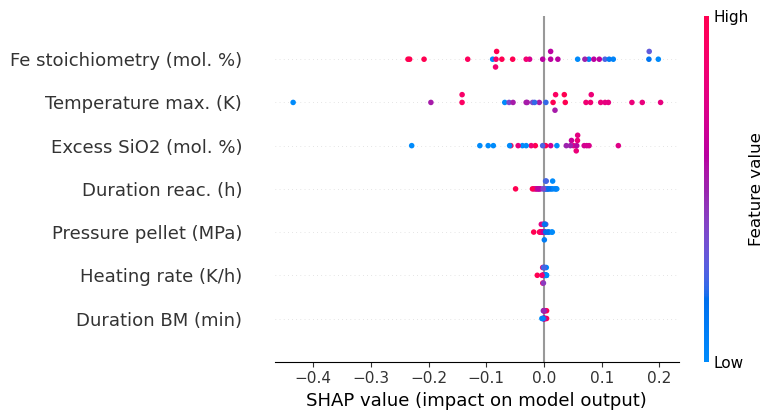

In [26]:
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        pred = trained_model(X_tensor)
    return pred.mean.numpy()

explainer = shap.Explainer(model_predict, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, feature_names=df_5.columns[2:9])

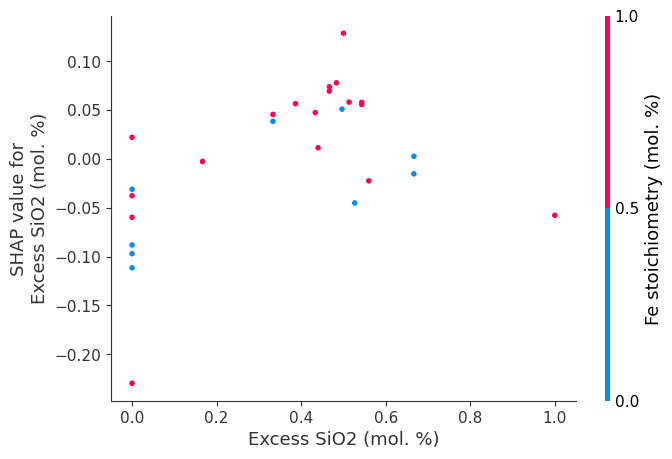

In [27]:
shap.dependence_plot(
    "Excess SiO2 (mol. %)", 
    shap_values.values,  
    X,  
    feature_names = df_5.columns[2:9],  
    interaction_index = "Fe stoichiometry (mol. %)"
)